# BLU6 - Learning Notebook - Optional part 4 - Cyclical Features

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

%matplotlib inline

### Cyclical Features

When dealing with time series, one of the first things data scientists are tempted to do in terms of feature engineering is to extract features from time series timestamps. Why? For several reasons:
* In a lot of time series, like number of sales, number of patients or number of bookings for a hotel on each day have a strong seasonality component. As such, information like what quarter, week or week day we are on is quite important.
* Unless you have the [time stone](https://bit.ly/2FND5RA) like [Dr. Strange](https://bit.ly/2Ije2uE) (or [Thanos](https://bit.ly/2I1lEP2), or [Adam Warlock](https://bit.ly/2jBftqy)) does, we can consider features extracted from the timestamp to be exogenous variables. So, no much thought is need for these features...or is it?

Let's start with a dataset about [Monthly Av. residential electricity usage Iowa city 1971 – 1979](https://bit.ly/2I0pU1k)

In [2]:
from utils import load_electricity_consumption_series

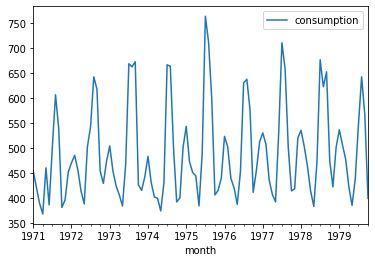

In [3]:
data = load_electricity_consumption_series()
data.plot();

In [4]:
data.head(5)

,consumption
month,
1971-01-01,454.0
1971-02-01,421.0
1971-03-01,389.0
1971-04-01,368.0
1971-05-01,460.0


as you can see, there is a (strong) seasonal component in the consumption (as expected). As such, we can extract features from timestamps that relate to the seasonality component in order to allow an arbitrary regression model to capture the season effects:

* semester number
* trimester number
* month number
* quarter number

we can't go below month because, as you can see, the observations are made monthly and, as such, there is no observed data for each month week or weekday. Let's extract those features

In [5]:
data_expanded = data.reset_index()
data_expanded.head(10)

,month,consumption
0,1971-01-01,454.0
1,1971-02-01,421.0
2,1971-03-01,389.0
3,1971-04-01,368.0
4,1971-05-01,460.0
5,1971-06-01,386.0
6,1971-07-01,501.0
7,1971-08-01,606.0
8,1971-09-01,539.0
9,1971-10-01,381.0


In [6]:
timestamps = data_expanded.month

data_expanded['month number'] = timestamps.dt.month
data_expanded['quarter number'] = timestamps.dt.quarter
data_expanded['trimester number'] = (timestamps.dt.month % 3) + 1
data_expanded['semester number'] = (timestamps.dt.month % 2) + 1

data_expanded.head(10)

,month,consumption,month number,quarter number,trimester number,semester number
0,1971-01-01,454.0,1,1,2,2
1,1971-02-01,421.0,2,1,3,1
2,1971-03-01,389.0,3,1,1,2
3,1971-04-01,368.0,4,2,2,1
4,1971-05-01,460.0,5,2,3,2
5,1971-06-01,386.0,6,2,1,1
6,1971-07-01,501.0,7,3,2,2
7,1971-08-01,606.0,8,3,3,1
8,1971-09-01,539.0,9,3,1,2
9,1971-10-01,381.0,10,4,2,1


I have a question for you: is January closer to December or to April? The obvious answer is "Ofcourse it is closer, what kind of question is that?!". Well, the issue is that, for the machine, the mapping between month name and number is the following:

* January: 1
* April: 4
* December: 12

Meaning that the distance between January and April will be smaller than the distance between January and December. given the fact that models like linear models, kNN, K-Means and neural networks are very sensitive to this difference, we need to preprocess this features we extracted. Usually, the first approach people take is encode features like this using a one hot encoder (remember the dummy encoder? that's the name in scikit learn). But this type of encoding will remove precious information about the order of each unique value (i.e. January comes before February, March after February, ...).

Instead of using the features as they are or encoding them as they were categorical, we can accept their **cyclical nature** and use encodings that leverage on that same nature. Imagine that we had observations on a hour basis. When we think about hours, we usually think about clocks. And, as we all know, traditional clock design tends to be circular

![wall_clock](images/wall-clock.jpg "")

in this kind of clocks, we **map** each daily **time measure** to a **point/line** in the **circle**. Can we do that sort of mapping using mathematical tools? 

Imagine that each daily time measure is a point in the circumference of a unit circle 

![unit_circle](images/unit-circle.png "")

for example, 00h00 would be at (1,0), 06h00 at (0,1), 12h00 at (-1,0) and 18h00 at (0,-1). If the time unit used was hour, our circle would be divided into 24 pieces. Now you are asking: what functions can I use to map the number of the hour ([0; 23]) to a point in the unit circle circumference, **in a continuous fashion**? For example, what would be the circumference point for 13h29m05s? Since we are using unit circles, we can apply **trignometric functions** to hour time measures in order to map them into the circle.

![circle_sin_cos](images/unit-circle-with-sin-cos.gif "")

You might be thinking "But...I don't have any angle and the picture you used has an angle...". True story, that is why we will show how to do it.

All operations we will perform are measured in radions. Remember: 360 degrees, in radians, is equal to 2$\pi$.

First, lets create an example dataframe with a time range spanning 1 day, with hourly time stamps.

In [7]:
example = pd.DataFrame(index=pd.date_range(start='February 1 2018', end='February 2 2018', freq='H'))
example.head(5)

""
2018-02-01 00:00:00
2018-02-01 01:00:00
2018-02-01 02:00:00
2018-02-01 03:00:00
2018-02-01 04:00:00


Lets add the *hour* column

In [8]:
example['hour'] = example.index.hour
example.head(5)

,hour
2018-02-01 00:00:00,0
2018-02-01 01:00:00,1
2018-02-01 02:00:00,2
2018-02-01 03:00:00,3
2018-02-01 04:00:00,4


In order to turn the values of the *hour* column into an angle, we can use the angle definition for discrete sinusoids.

$$\theta = \frac{2 k \pi}{N}$$

where, in this specific context of feature engineering, $N$ is the number of arbitrary divisions you want to make to the unit circle (e.g. the number of hours in each day) or the maximum value we have for the feature and $k$ is the "index" of the value you want to map or the value of the feature. For example, for the mapping we created in the example dataframe, $k=0$ for 00h00, $k=3$ for 03h00. Now, you might be wondering "How do I map things like 00h30?". The answer is: do an interpolation of some sort between $k=0$ and $k=1$. For 00h30, we would recommend $k=0.5$. Now, let's get the unit circle representation for the hour

In [9]:
example['hour (sin)'] = np.sin((2. * example['hour'] *  np.pi / 24))
example['hour (cos)'] = np.cos((2. * example['hour'] *  np.pi / 24))

In [10]:
example.head(5)

,hour,hour (sin),hour (cos)
2018-02-01 00:00:00,0,0.000000,1.000000
2018-02-01 01:00:00,1,0.258819,0.965926
2018-02-01 02:00:00,2,0.500000,0.866025
2018-02-01 03:00:00,3,0.707107,0.707107
2018-02-01 04:00:00,4,0.866025,0.500000


Finally, let's look at the time series for these two new features

<AxesSubplot:>

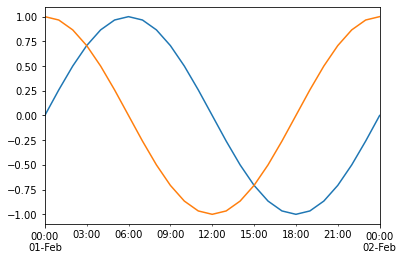

In [11]:
example['hour (sin)'].plot()
example['hour (cos)'].plot()